# Exploration of the WT1-126 and WT1-37 data set

In [1]:
import os

import collections
import matplotlib as mpl
import matplotlib.backends.backend_pdf
from matplotlib.font_manager import FontProperties
import matplotlib.patches as mpatches
from matplotlib.patches import PathPatch
import matplotlib.pyplot as plt
from matplotlib.text import TextPath
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns

from clustcr import datasets, read_cdr3, metarepertoire, Clustering, ClusterAnalysis

# Adjust the working directory
os.chdir('path_to_your_dir')

# Define the directory to store all results
results_dir = './results/clustering/training_data'


# Assign volunteer names to every unique CDR3

In [2]:
def get_volunteer(cdr3,data):
    volunteer = data[data['CDR3_beta']==cdr3]['volunteer'].tolist()[0]
    return volunteer

def get_genes(cdr3,data):
    vgene = data[data['CDR3_beta']==cdr3]['TRBV_gene'].tolist()
    jgene = data[data['CDR3_beta']==cdr3]['TRBJ_gene'].tolist()
    return vgene,jgene

def assign_volunteer_colors(graph, data):
    
    color_map = []
    colored_categories= []
    color_legend = []
    # color code: https://davidmathlogic.com/colorblind
    # Generate color dict
    categories=set(data['volunteer'].tolist())
    category_dir={}
    palette = ['#D55E00','#F2035A','#56B4E9',
               '#009E73','#1E24E9','#AEB1B0',
               '#CC79A7','#00FF6E','#6E4C82',
               '#562F83','#D0E10A','#C100C0',
               '#B7A68C']
    for cat, nr in zip(sorted(categories),range(0,len(categories),1)):
        category_dir[cat] = palette[nr] 
    category_dir['public'] = '#000000'
        
    # Assign color to cluster
    for node in graph:
        cat = get_volunteer(node,data)
        color_map.append(category_dir[cat])
        if cat not in colored_categories:
            # Generate color legend
            color_legend.append(mpatches.Patch(color=category_dir[cat], label=cat))
            colored_categories.append(cat)
    
    return color_map, color_legend  


In [3]:
# Import all TCRs
all_tcrs = pd.read_csv('./data/parsed_data/full_filtered_dataset.tsv')

# Link each unique CDR3 with one/more volunteers
grouped_volunteer = (all_tcrs.groupby(['CDR3_beta'])['volunteer'].apply(', '.join)
                     .reset_index().set_index(['CDR3_beta']))
grouped_volunteer['volunteer'] = grouped_volunteer['volunteer'].apply(
    lambda x: x if ',' not in str(x) else ','.join(set(y.strip()
                                                   for y in x.split(','))))
grouped_volunteer = grouped_volunteer.reset_index()

# Mark public CDR3s
grouped_volunteer['volunteer'] = grouped_volunteer['volunteer'].apply(lambda x: 'public' if ',' in x else x)
grouped_volunteer 

,CDR3_beta,volunteer
0,CAARRWDSVSYEQYF,DR10
1,CAASDDRVGEQFF,DR18
2,CACGTAVTEAFF,DR24
3,CACSDDRATQETQYF,DR18
4,CACSLGGASGASETQYF,DR24
...,...,...
1538,CVTSTRQGGSEQYF,DR18
1539,CYSSDDRVGEQFF,DR12
1540,CYSSFQGYTEAFF,DR26
1541,CYSSLQGRHGYTF,DR26


# Cluster WT1-specific data

In [4]:
def cluster_data(data):
    clustering = Clustering(faiss_training_data=data['CDR3_beta'], 
                            fitting_data_size=len(data['CDR3_beta']),
                            max_sequence_size=data['CDR3_beta'].str.len().max(),
                            n_cpus=8)
    
    clustered_data = clustering.fit(data['CDR3_beta'])
    clustering.batch_cleanup()
    return clustered_data


def get_graph(clustered_data, file_name):
    
    # Create graph from edges
    clustered_data.export_network(filename=file_name)
    edges = pd.read_csv(file_name, sep='\t', header=None)

    # Entire graph
    G = nx.from_pandas_edgelist(edges, source=0, target=1)
    
    return G


def get_node_sizes(graph):
    counts = []
    for component in list(nx.connected_components(graph)):
        counts.append(len(component))    
    return counts


# Amino acid motif logos
fp = FontProperties(family="Arial", weight="bold")
globscale = 1.35
LETTERS = {"G": TextPath((-0.384, 0), "G", size=1, prop=fp),
           "A": TextPath((-0.35, 0), "A", size=1, prop=fp),
           "S": TextPath((-0.37, 0), "S", size=1, prop=fp),
           "T": TextPath((-0.305, 0), "T", size=1, prop=fp),
           "C": TextPath((-0.366, 0), "C", size=1, prop=fp),
           "V": TextPath((-0.37, 0), "V", size=1, prop=fp),
           "I": TextPath((-0.37, 0), "I", size=1, prop=fp),
           "L": TextPath((-0.37, 0), "L", size=1, prop=fp),
           "P": TextPath((-0.37, 0), "P", size=1, prop=fp),
           "F": TextPath((-0.37, 0), "F", size=1, prop=fp),
           "Y": TextPath((-0.37, 0), "Y", size=1, prop=fp),
           "M": TextPath((-0.37, 0), "M", size=1, prop=fp),
           "W": TextPath((-0.37, 0), "W", size=1, prop=fp),
           "N": TextPath((-0.37, 0), "N", size=1, prop=fp),
           "Q": TextPath((-0.39, 0), "Q", size=1, prop=fp),
           "H": TextPath((-0.37, 0), "H", size=1, prop=fp),
           "D": TextPath((-0.37, 0), "D", size=1, prop=fp),
           "E": TextPath((-0.37, 0), "E", size=1, prop=fp),
           "K": TextPath((-0.37, 0), "K", size=1, prop=fp),
           "R": TextPath((-0.37, 0), "R", size=1, prop=fp)}

# https://davidmathlogic.com/colorblind/#%23000000-%2356B4E9-%23009E73-%23F0E442-%23D55E00
COLOR_SCHEME = {'G': '#56B4E9', # non polar: G,A,P,V,L,I,M
                'A': '#56B4E9',
                'P': '#56B4E9',
                'V': '#56B4E9',
                'L': '#56B4E9',
                'I': '#56B4E9',
                'M': '#56B4E9',
                # Aromatic: F,Y,W
                'F': '#F0E442',
                'Y': '#F0E442',
                'W': '#F0E442',
                # Polar, no charge: S,T,C,N,Q
                'S': '#009E73',
                'T': '#009E73',
                'C': '#009E73',
                'N': '#009E73',
                'Q': '#009E73',
                # Negative charge: D,E
                'D': '#D55E00',
                'E': '#D55E00',
                # Positive charge: K,H,R
                'K': '#000000',
                'H': '#000000',
                'R': '#000000'}


def letterAt(letter, x, y, yscale=1, ax=None):
    text = LETTERS[letter]

    t = mpl.transforms.Affine2D().scale(1*globscale, yscale*globscale) + mpl.transforms.Affine2D().translate(x, y) + ax.transData
    p = PathPatch(text, lw=0, fc=COLOR_SCHEME[letter],  transform=t)
    if ax is not None:
        ax.add_artist(p)
    return p


def seq2matrix(seqArray, weights=None):
    # Enumerate each character at each position
    maxlength = max([len(seq) for seq in seqArray])

    matrix = []

    for x in range(maxlength):
        characters = [seq[x] for seq in seqArray if len(seq) > x]
        counter = collections.Counter(characters)
        if weights is None:
            matrix.append(counter.most_common())
        else:
            counts = list()
            for (base, count) in counter.most_common():
                # Gets a bit complicated as the central position is equal to 0,
                # only if it exists. maxlength-1 as indexing starts at 0
                if x < (maxlength-1)/2:
                    counts.append((base, count*weights[int(x-((maxlength-1)/2) - 0.5)]))
                elif x > (maxlength-1)/2:
                    counts.append((base, count*weights[int(x-((maxlength-1)/2) + 0.5)]))
                elif x == (maxlength-1)/2:
                    counts.append((base, count*weights[0]))
            matrix.append(counts)

    return matrix


def motif_logo(all_scores):
    # Generate a motif logo, should have seq2matrix as input
    plt.figure()
    fig, ax = plt.subplots(figsize=(10, 3))

    x = 1
    maxi = 0
    for scores in all_scores:
        y = 0
        for base, score in scores:
            letterAt(base, x, y, score, ax)
            y += score
        x += 1
        maxi = max(maxi, y)

    plt.xticks(range(1, x))
    plt.xlim((0, x))
    plt.ylim((0, maxi))
    plt.tight_layout()

    return plt


def filter_clusters(cluster_results, nr):
    cluster_size = cluster_results.groupby('cluster').count().reset_index()
    clusters = cluster_size[cluster_size['CDR3'] >= nr]['cluster']
    return cluster_size,list(clusters)

def create_logos(clustered_data, size, epitope):
    
    # Select clusters with minimal size
    cluster_results = clustered_data.clusters_df
    cluster_size, all_clusters = filter_clusters(cluster_results,size)
    print(cluster_results[cluster_results['cluster'].isin(all_clusters)])
    cluster_results['genes'] = cluster_results['CDR3'].apply(lambda row: get_genes(row,genes) )
    
    # Generate seq logo for every selected cluster
    for i in all_clusters:
        select = cluster_results[cluster_results['cluster'] == i]
        print(select)
        print('cluster size:', len(select), 'for cluster', i)
        fig = motif_logo(seq2matrix(np.array(list(select['CDR3']))))
        fig.savefig(os.path.join(results_dir, epitope+'_seq_logo'+str(i)+'.jpeg'),dpi=1200)
    
    return cluster_size



# Count the number of clusters derived from multiple volunteers
def retrieve_public_clusters(clustered_data, grouped_volunteer):

    # Concat the volunteer info with the cluster info
    volunteer_info = grouped_volunteer.set_index('CDR3_beta')
    clusters_epitope = clustered_data.clusters_df
    clusters_epitope = clusters_epitope.rename(columns={'CDR3':'CDR3_beta'})
    clusters_epitope = clusters_epitope.set_index('CDR3_beta')

    # Filter the clusters with multiple volunteers
    cluster_info = pd.concat([clusters_epitope, volunteer_info],axis=1).dropna()
    cluster_info = (cluster_info.groupby(['cluster'])['volunteer'].apply(', '.join)
                    .reset_index())
    cluster_info['volunteer'] = cluster_info['volunteer'].apply(
        lambda x: x if ',' not in str(x) else ','.join(set(y.strip()
                                                       for y in x.split(','))))
    # Public TCRs are also present in multiple volunteers
    cluster_info['volunteer'] = cluster_info['volunteer'].apply(lambda x: 'public,' if x == 'public' else x)
    public_clusters = cluster_info[cluster_info['volunteer'].str.contains(',')]
    
    return public_clusters

In [5]:
# Link each unique CDR3 with one/more volunteers
grouped_v = (all_tcrs.groupby(['CDR3_beta'])['TRBV_gene'].apply(', '.join)
                     .reset_index().set_index(['CDR3_beta']))
grouped_v['TRBV_gene'] = grouped_v['TRBV_gene'].apply(
    lambda x: x if ',' not in str(x) else ','.join(set(y.strip()
                                                   for y in x.split(','))))
grouped_j = (all_tcrs.groupby(['CDR3_beta'])['TRBJ_gene'].apply(', '.join)
                     .reset_index().set_index(['CDR3_beta']))
grouped_j['TRBJ_gene'] = grouped_j['TRBJ_gene'].apply(
    lambda x: x if ',' not in str(x) else ','.join(set(y.strip()
                                                   for y in x.split(','))))

genes = pd.concat([grouped_v,grouped_j],axis=1).reset_index()
genes

,CDR3_beta,TRBV_gene,TRBJ_gene
0,CAARRWDSVSYEQYF,TRBV6-5,TRBJ2-7
1,CAASDDRVGEQFF,TRBV24-1,TRBJ2-1
2,CACGTAVTEAFF,TRBV12-3,TRBJ1-1
3,CACSDDRATQETQYF,TRBV19,TRBJ2-5
4,CACSLGGASGASETQYF,TRBV28,TRBJ2-5
...,...,...,...
1538,CVTSTRQGGSEQYF,TRBV15,TRBJ2-7
1539,CYSSDDRVGEQFF,TRBV24-1,TRBJ2-1
1540,CYSSFQGYTEAFF,TRBV28,TRBJ1-1
1541,CYSSLQGRHGYTF,TRBV28,TRBJ1-2


### WT1-126

In [6]:
# Read WT1-126 specific TCRs
data_126 = pd.read_csv('./data/parsed_data/tcrex_training_data/WT1-126_count1/20210811_target.tsv',
                      sep='\t')

data_126 = data_126.merge(grouped_volunteer,how='inner', on=['CDR3_beta'])

# Cluster WT1-126 specific TCRs
clustered_data = cluster_data(data_126)
public_clusters = retrieve_public_clusters(clustered_data, grouped_volunteer)
print(public_clusters.shape[0])


Total time to run '_twostep': 0.301s
12


34 WT1-126 specific TCRs clustered
{2: 14, 3: 2}


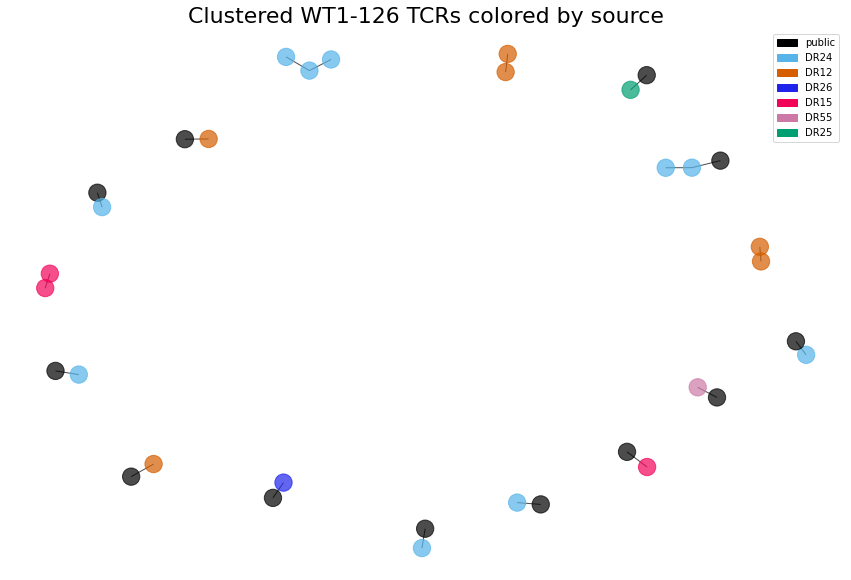

In [7]:
G = get_graph(clustered_data, os.path.join(results_dir,'edges_126.txt'))
print(G.number_of_nodes(), 'WT1-126 specific TCRs clustered')

# Draw graph with colors
plt.rcParams['figure.figsize'] = [15, 10]
plt.title('Clustered WT1-126 TCRs colored by source',fontsize=22)
color_map, color_legend = assign_volunteer_colors(G,data_126)
pos = nx.spring_layout(G, seed=1)
nx.draw(G, pos = pos,node_color = color_map, with_labels = False,alpha=0.7)
plt.legend(loc='best', handles=color_legend)
plt.savefig(os.path.join(results_dir, 'all_clusters_wt1_126.jpeg'),dpi=1200)

nr_nodes= get_node_sizes(G)
print({x:nr_nodes.count(x) for x in sorted(nr_nodes)})

                 CDR3  cluster
6   CASSLLNRDTGNQPQHF        3
7   CASSLLNWDTGNQPQHF        3
8   CASSLLNWDTDNQPQHF        3
17       CASNRGHTEAFF        8
18       CASNRGYTEAFF        8
19       CASDRGYTEAFF        8
                CDR3  cluster                   genes
6  CASSLLNRDTGNQPQHF        3  ([TRBV7-9], [TRBJ1-5])
7  CASSLLNWDTGNQPQHF        3  ([TRBV7-9], [TRBJ1-5])
8  CASSLLNWDTDNQPQHF        3  ([TRBV7-9], [TRBJ1-5])
cluster size: 3 for cluster 3
            CDR3  cluster                    genes
17  CASNRGHTEAFF        8  ([TRBV25-1], [TRBJ1-1])
18  CASNRGYTEAFF        8  ([TRBV25-1], [TRBJ1-1])
19  CASDRGYTEAFF        8  ([TRBV25-1], [TRBJ1-1])
cluster size: 3 for cluster 8


<Figure size 1080x720 with 0 Axes>

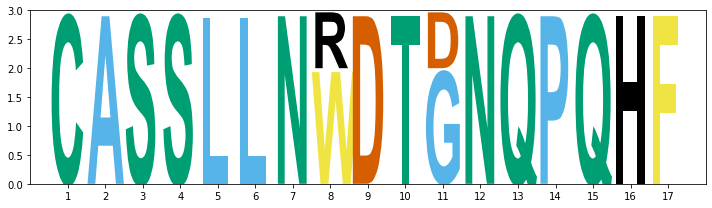

<Figure size 1080x720 with 0 Axes>

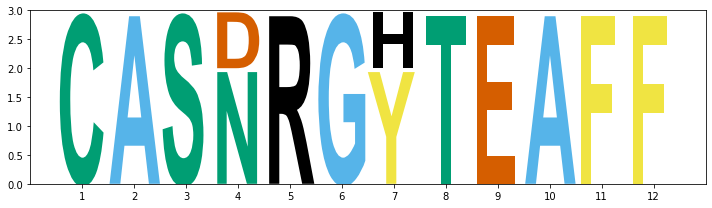

In [8]:
cluster_size = create_logos(clustered_data, 3, 'wt1_126')

## Check that clusters are overlapping with graphs

In [9]:
def assign_cluster_colors(graph, data):
    
    color_map = []
    colored_categories= []
    color_legend = []
    # Generate color dict
    categories = set(data['cluster'].tolist())
    categories = [str(x) for x in categories]
    category_dir = {}
    palette = sns.color_palette("husl",len(categories))
    for cat, nr in zip(categories,range(0,len(categories),1)):
        category_dir[cat] = palette[nr] 
  
    # Assign color to cluster
    for node in graph:
        cat = str(data[data['CDR3_beta']==node]['cluster'].tolist()[0])
        color_map.append(category_dir[cat])
        if cat not in colored_categories:
            # Generate color legend
            color_legend.append(mpatches.Patch(color=category_dir[cat], label=cat))
            colored_categories.append(cat)
    
    return color_map, color_legend

34 WT1-126 specific TCRs clustered
{2: 14, 3: 2}


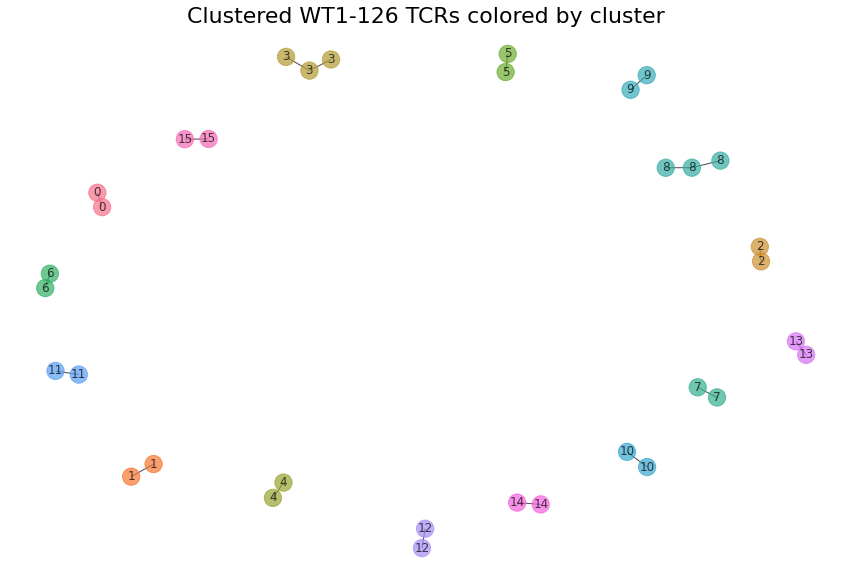

In [10]:
cls = clustered_data.clusters_df
cls = cls.rename(columns = {'CDR3':'CDR3_beta'})
data_126 = data_126.merge(cls,how='inner', on=['CDR3_beta'])
dict_126 = {}
for index, row in data_126.iterrows():
    dict_126[row['CDR3_beta']]= row['cluster']

G = get_graph(clustered_data, os.path.join(results_dir,'edges_126.txt'))
print(G.number_of_nodes(), 'WT1-126 specific TCRs clustered')

# Draw graph with colors
plt.rcParams['figure.figsize'] = [15, 10]
plt.title('Clustered WT1-126 TCRs colored by cluster',fontsize=22)
color_map, color_legend = assign_cluster_colors(G,data_126)
pos = nx.spring_layout(G, seed=1)
nx.draw(G, pos = pos,node_color = color_map, with_labels = True,alpha=0.7,labels=dict_126)

nr_nodes= get_node_sizes(G)
print({x:nr_nodes.count(x) for x in sorted(nr_nodes)}) 

### WT1-137

In [11]:
# Read WT1-37 specific TCRs
data_37 = pd.read_csv('./data/parsed_data/tcrex_training_data/WT1-37_count1/20210811_target.tsv',
                      sep='\t')

data_37 = data_37.merge(grouped_volunteer,how='inner', on=['CDR3_beta'])

# Cluster WT1-37 specific TCRs
clustered_data = cluster_data(data_37)
public_clusters = retrieve_public_clusters(clustered_data, grouped_volunteer)
print(public_clusters.shape[0])


Total time to run '_twostep': 0.529s
70


In [12]:
public_clusters['counts'] =  public_clusters.volunteer.str.count(',') + 1
public_clusters.sort_values(by='counts', ascending=False)

,cluster,volunteer,counts
0,0.0,"DR24,DR12,DR23,public,DR18",5
4,4.0,"DR25,DR23,DR26,public",4
8,8.0,"public,DR23,DR24,DR12",4
148,148.0,"public,DR26,DR25",3
90,90.0,"DR50,public,DR47",3
...,...,...,...
59,59.0,"DR10,public",2
61,61.0,"DR10,public",2
63,63.0,"DR10,public",2
2,2.0,"DR10,public",2


411 WT1-37 specific TCRs clustered
{2: 124, 3: 31, 4: 7, 5: 1, 8: 1, 11: 1, 18: 1}


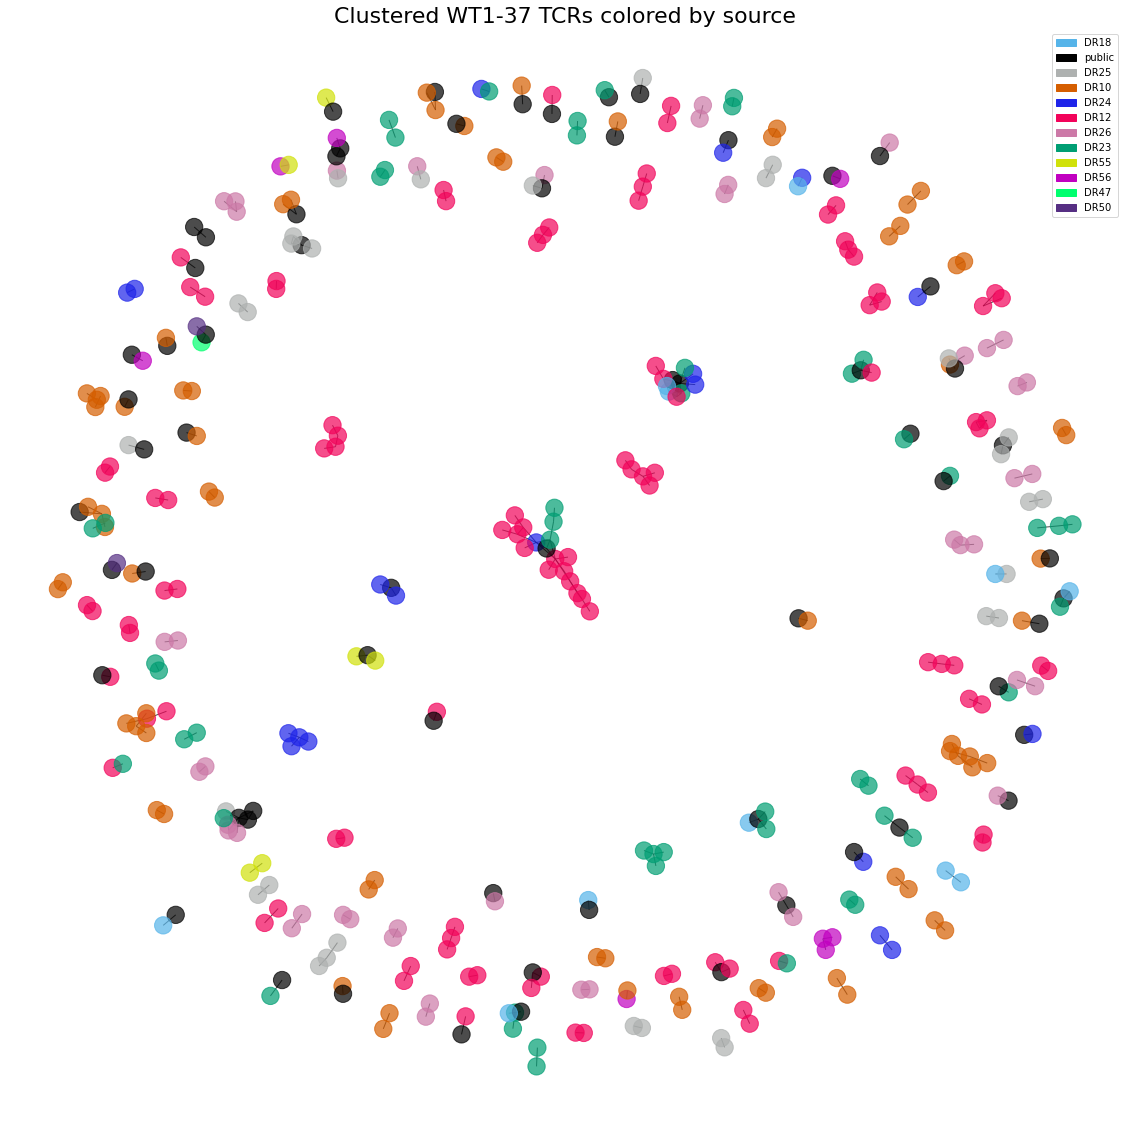

In [13]:
G = get_graph(clustered_data, os.path.join(results_dir,'edges_37.txt'))
print(G.number_of_nodes(), 'WT1-37 specific TCRs clustered')

# Draw graph with colors
plt.rcParams['figure.figsize'] = [20, 20]
plt.title('Clustered WT1-37 TCRs colored by source',fontsize=22)
color_map, color_legend = assign_volunteer_colors(G,data_37)
pos = nx.spring_layout(G, seed=1)
nx.draw(G, pos = pos,node_color = color_map, with_labels = False,alpha=0.7)
plt.legend(loc='best', handles=color_legend)
plt.savefig( os.path.join(results_dir, 'all_clusters_wt1_37.jpeg'),dpi=1200)

nr_nodes= get_node_sizes(G)
print({x:nr_nodes.count(x) for x in sorted(nr_nodes)})

               CDR3  cluster
0      CATSDDRVGEQF        0
1     CATSDDRVGERFF        0
2     CATSDDRVGEQFF        0
3     CATSYDRVGEQFF        0
4     CFTSDDRVGEQFF        0
..              ...      ...
204  CASSLTLWAHEQYF       71
337    CASSSTESEQFF      131
338    CASSSTETEQFF      131
339    CASSSTETEQLF      131
340    CASRSTETEQFF      131

[70 rows x 2 columns]
             CDR3  cluster                    genes
0    CATSDDRVGEQF        0  ([TRBV24-1], [TRBJ2-1])
1   CATSDDRVGERFF        0  ([TRBV24-1], [TRBJ2-1])
2   CATSDDRVGEQFF        0  ([TRBV24-1], [TRBJ2-1])
3   CATSYDRVGEQFF        0  ([TRBV24-1], [TRBJ2-1])
4   CFTSDDRVGEQFF        0  ([TRBV24-1], [TRBJ2-1])
5   CATSDDGLGEQFF        0  ([TRBV24-1], [TRBJ2-1])
6   CATSDDGVGEQFF        0  ([TRBV24-1], [TRBJ2-1])
7   CAASDDRVGEQFF        0  ([TRBV24-1], [TRBJ2-1])
8   CATSGDRVGEQFF        0  ([TRBV24-1], [TRBJ2-1])
9   CATSDDRMGEQFF        0  ([TRBV24-1], [TRBJ2-1])
10  CATCDDRVGEQFF        0  ([TRBV24-1], [TRBJ2-1])
clust

/Users/sofiegielis/miniconda3/envs/external_support/lib/python3.6/site-packages/ipykernel_launcher.py:121: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<Figure size 1440x1440 with 0 Axes>

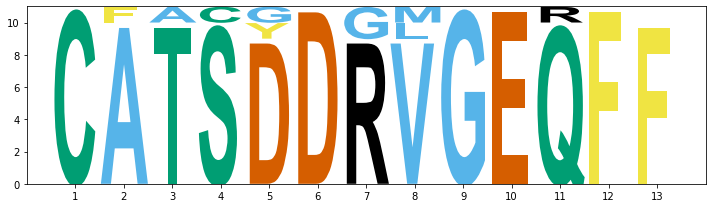

<Figure size 1440x1440 with 0 Axes>

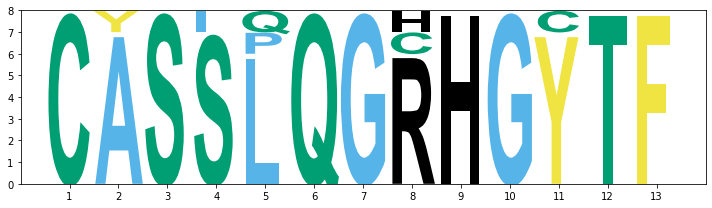

<Figure size 1440x1440 with 0 Axes>

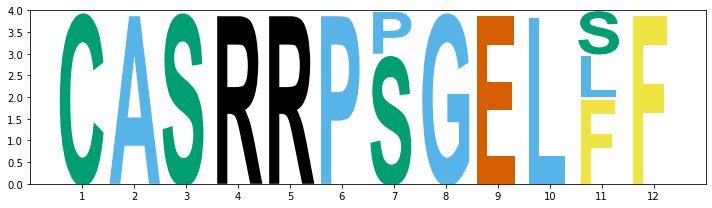

<Figure size 1440x1440 with 0 Axes>

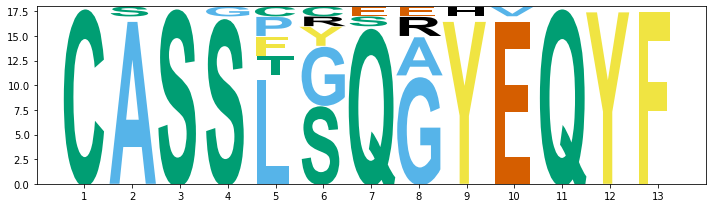

<Figure size 1440x1440 with 0 Axes>

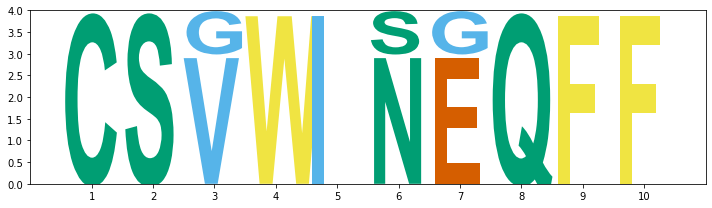

<Figure size 1440x1440 with 0 Axes>

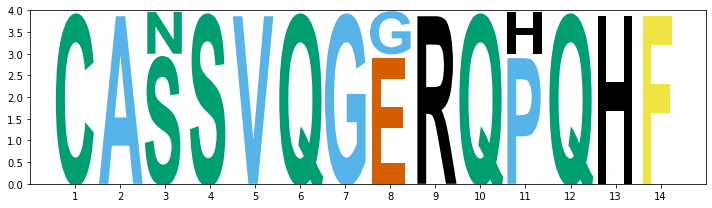

<Figure size 1440x1440 with 0 Axes>

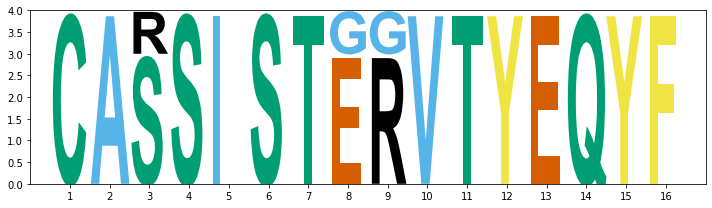

<Figure size 1440x1440 with 0 Axes>

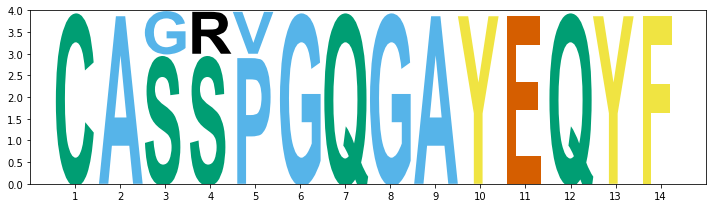

<Figure size 1440x1440 with 0 Axes>

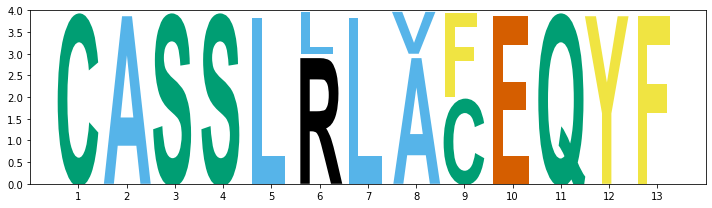

<Figure size 1440x1440 with 0 Axes>

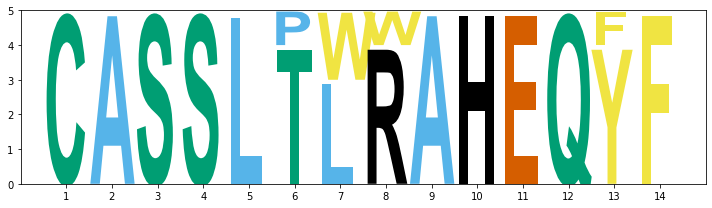

<Figure size 1440x1440 with 0 Axes>

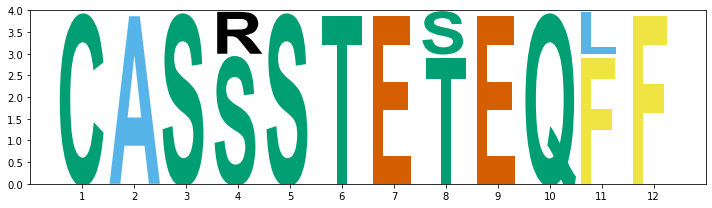

In [14]:
cluster_size = create_logos(clustered_data, 4, 'wt1_37')

In [15]:
cls = clustered_data.clusters_df
cls = cls.rename(columns = {'CDR3':'CDR3_beta'})
data_37 = data_37.merge(cls,how='inner', on=['CDR3_beta'])
dict_37 = {}
for index, row in data_37.iterrows():
    dict_37[row['CDR3_beta']]= row['cluster']

411 WT1-37 specific TCRs clustered
{2: 124, 3: 31, 4: 7, 5: 1, 8: 1, 11: 1, 18: 1}


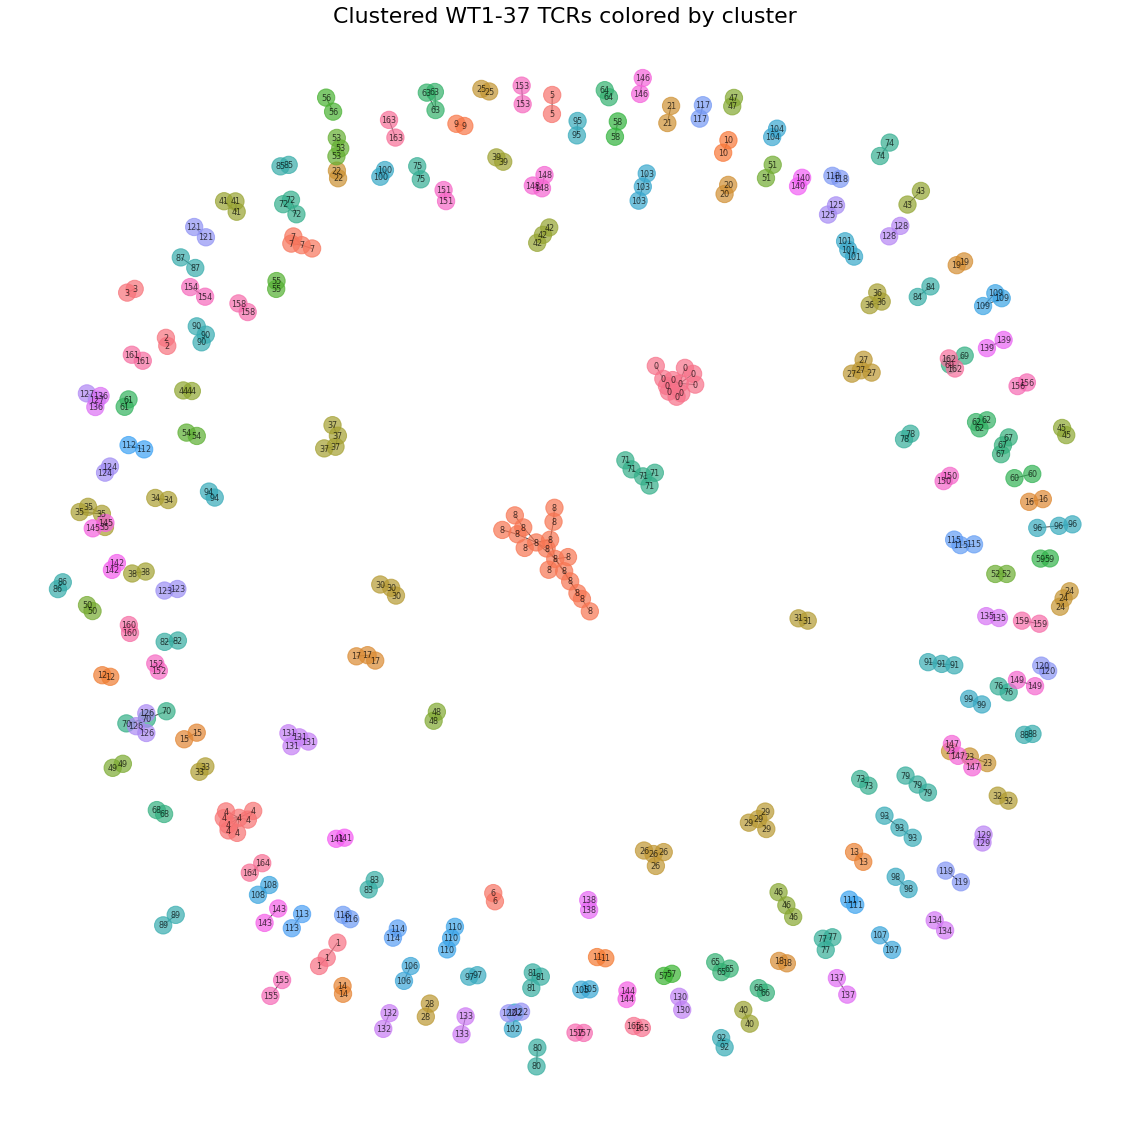

In [16]:
G = get_graph(clustered_data, os.path.join(results_dir,'edges_37.txt'))
print(G.number_of_nodes(), 'WT1-37 specific TCRs clustered')

# Draw graph with colors
plt.rcParams['figure.figsize'] = [20, 20]
plt.title('Clustered WT1-37 TCRs colored by cluster',fontsize=22)
color_map, color_legend = assign_cluster_colors(G,data_37)
pos = nx.spring_layout(G, seed=1)
nx.draw(G, pos = pos,node_color = color_map, with_labels = True,alpha=0.7,labels=dict_37,font_size=8)

nr_nodes= get_node_sizes(G)
print({x:nr_nodes.count(x) for x in sorted(nr_nodes)}) 

In [17]:
def retain_large_nodes(graph, size):
    for component in list(nx.connected_components(graph)):
        if len(component) < size:
            for node in component:
                graph.remove_node(node)
    return graph

In [18]:
G_large = retain_large_nodes(G, 3)

In [19]:
sizes = cls.groupby('cluster').size().reset_index()
selected_clusters = sizes[sizes[0]>2]['cluster'].tolist()
large_clusters = cls[cls['cluster'].isin(selected_clusters)]

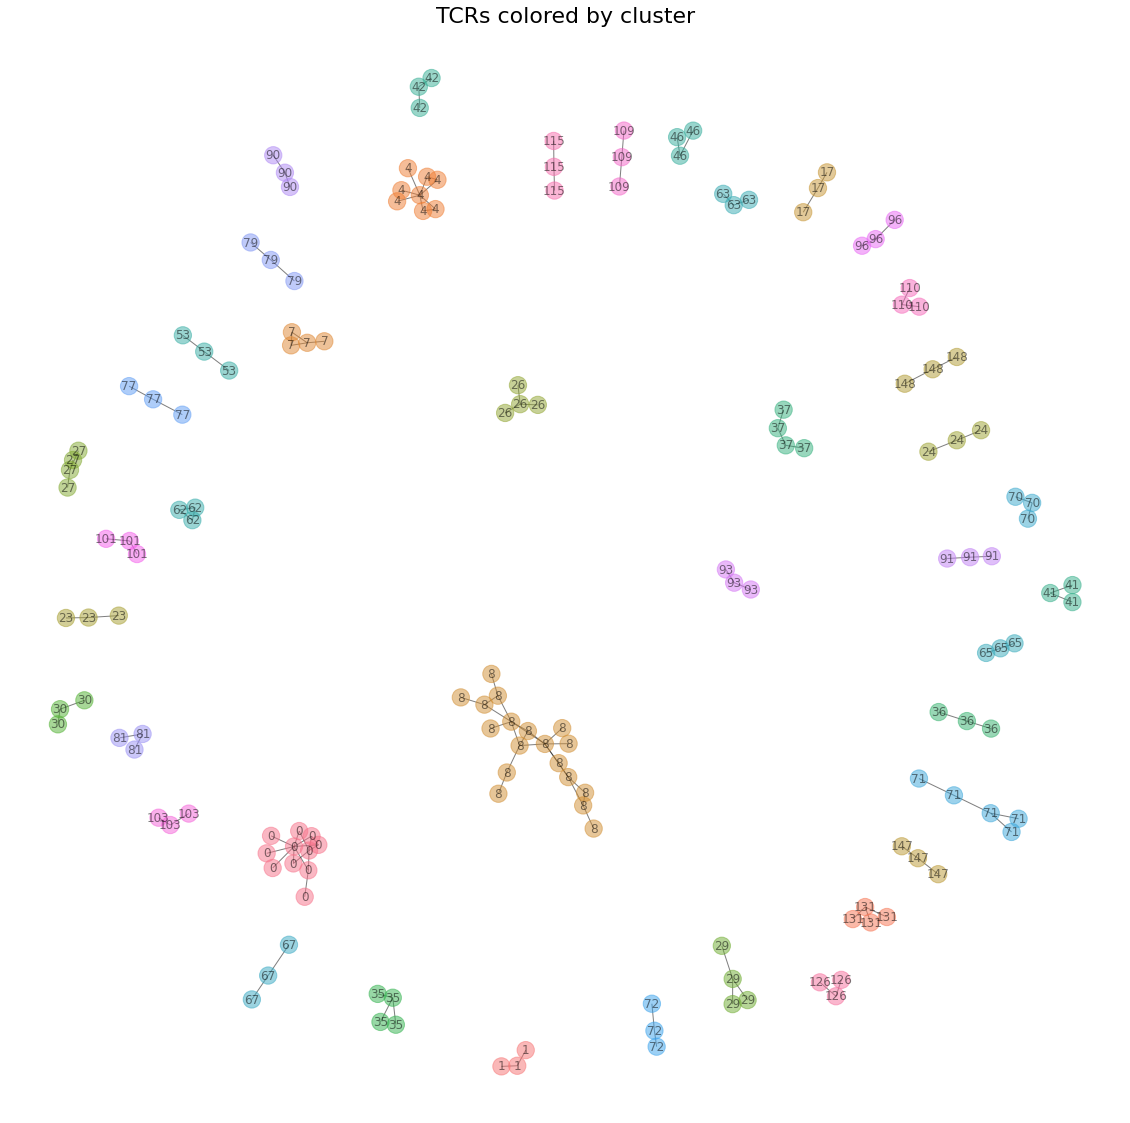

In [20]:
labels ={}
for index, row in large_clusters.iterrows():
    labels[row['CDR3_beta']]= row['cluster']

# Draw graph with colors
plt.rcParams['figure.figsize'] = [20, 20]
plt.title('TCRs colored by cluster',fontsize=22)
color_map, color_legend = assign_cluster_colors(G_large,large_clusters)
pos = nx.spring_layout(G_large, seed=1)
nx.draw(G_large, pos = pos,node_color = color_map, with_labels = True,alpha=0.5,labels=labels)
